In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


c:\Users\DELL\anaconda3\envs\gpu_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


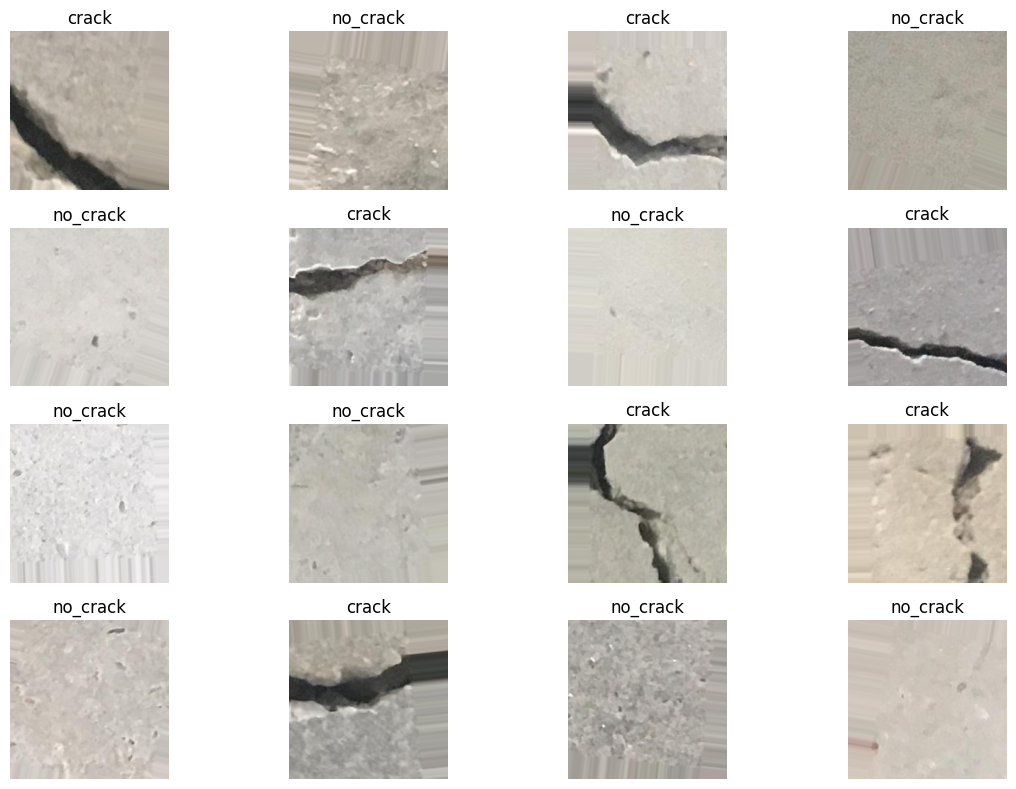

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a batch of images from a generator
def visualize_batch(generator, class_names=None):
    images, labels = next(generator)  # Get one batch
    plt.figure(figsize=(12, 8))
    for i in range(min(16, len(images))):  # Display up to 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        if class_names:
            title = class_names[int(labels[i])]
        else:
            title = f"Label: {int(labels[i])}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Optional: get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Call the function with your train_generator
visualize_batch(train_generator, class_names)


In [3]:
# Import TensorFlow into jupyter notebook
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSSS!!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :()")

TF version:  2.10.0
TF Hub version:  0.16.1
GPU available (YESSSSSS!!!!!!!)


In [3]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


Model Creation

In [4]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# === CONFIG ===
data_dir = 'dataset'  # change this to your actual path
batch_size = 32
num_epochs = 10
learning_rate = 0.001
use_mobilenet = True  # Set False if you want ResNet18

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMS ===
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# === LOAD DATASETS ===
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# === LOAD PRETRAINED MODEL ===
if use_mobilenet:
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# === LOSS AND OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# === TRAINING FUNCTION ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    train_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print()

    print(f"Best Val Acc: {best_acc:.4f}")
    return model

# === TRAIN THE MODEL ===
#trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)


c:\Users\DELL\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# === TRAIN THE MODEL ===
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

In [6]:
!pip3 install scikit-learn


   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ------------------ --------------------- 4.2/9.3 MB 25.0 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 26.2 MB/s eta 0:00:00


In [5]:
#Evaluation on test set
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === LOAD BEST MODEL ===
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# === EVALUATE ===
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


C:\Users\DELL\AppData\Local\Temp\ipykernel_2216\3503210509.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Classification Report:
              precision    recall  f1-score   support

       crack       1.00      1.00      1.00      3000
    no_crack       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
[[2996    4]
 [   3 2997]]


In [7]:
!pip install seaborn

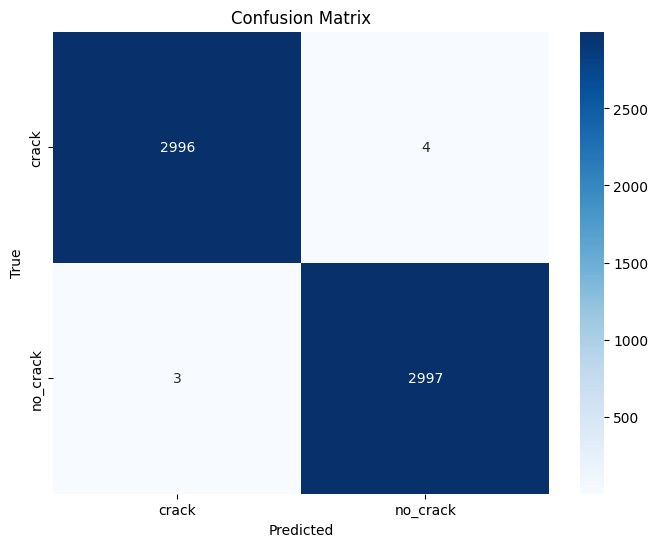

In [8]:
# Plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
plot_confusion_matrix(all_labels, all_preds, class_names)


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of output classes (binary classification)
num_classes = 2

# Load MobileNetV2
model = models.mobilenet_v2(pretrained=False)

# Modify classifier to match number of classes
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Load saved weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Move model to device
model = model.to(device)
model.eval()


C:\Users\DELL\AppData\Local\Temp\ipykernel_11816\185114854.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Binary classification
num_classes = 2

# Define and load MobileNetV2
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Load trained weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()


C:\Users\DELL\AppData\Local\Temp\ipykernel_11816\2935641615.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def show_sample_predictions(model, dataloader, class_names, device, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train()
                    return


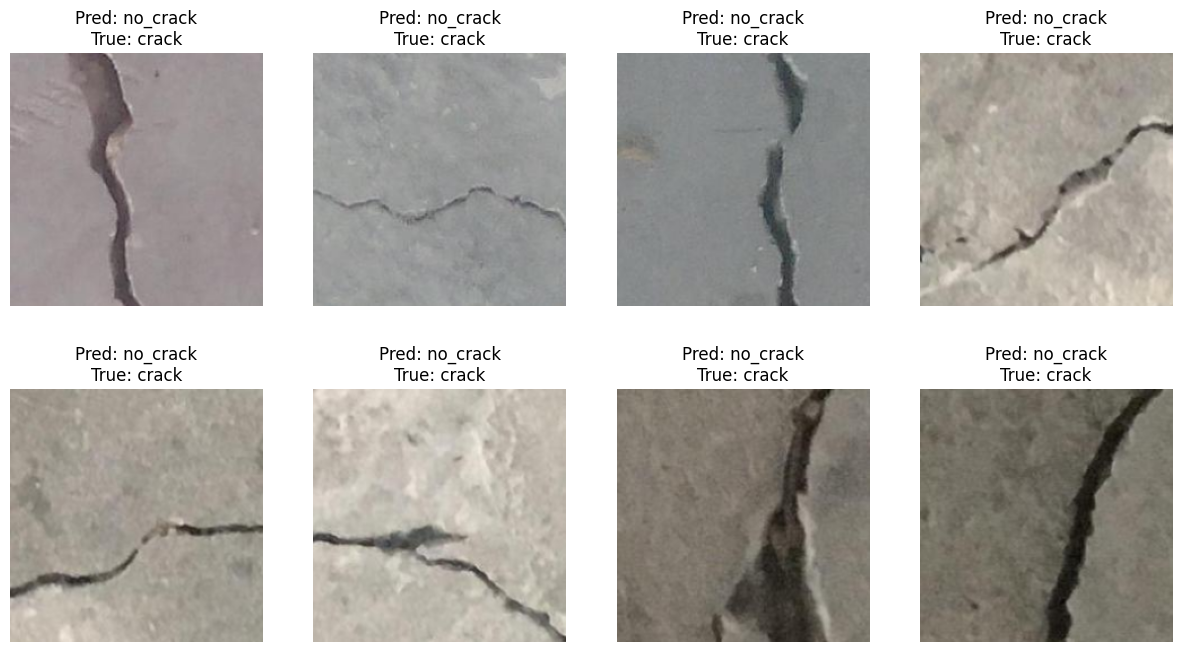

In [13]:
show_sample_predictions(model, dataloaders['test'], class_names, device, num_images=8)


In [14]:
torch.save(model.state_dict(), "best_model.pth")


In [3]:
#Mobile app development
#Convert the model to a TorchScript format (.pt or .ptl).

# Load best model
import torch
import torch.nn as nn
from torchvision import models

# Define number of classes (make sure it matches your training)
num_classes = 2  # Replace with your actual number of classes

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === RELOAD THE MODEL STRUCTURE ===
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
model.to(device)

# === CONVERT TO TORCHSCRIPT ===
example = torch.rand(1, 3, 224, 224).to(device)
traced_script_module = torch.jit.trace(model, example)

# === SAVE THE MODEL ===
traced_script_module.save("crack_detector.pt")
print("Model saved as crack_detector.pt")


c:\Users\DELL\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9988\3527326650.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/p

Model saved as crack_detector.pt
